In [1]:
import numpy as np
import pandas as pd 
import tensorflow as tf
import seaborn as sns
sns.set(context='notebook',style='whitegrid',palette='dark')
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv('ex1data1.txt',names=['population','profit'])   #读入文件并给每列明敏

In [3]:
df.head(12)

,population,profit
0,6.1101,17.5920
1,5.5277,9.1302
2,8.5186,13.6620
3,7.0032,11.8540
4,5.8598,6.8233
5,8.3829,11.8860
6,7.4764,4.3483
7,8.5781,12.0000
8,6.4862,6.5987
9,5.0546,3.8166


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 2 columns):
population    97 non-null float64
profit        97 non-null float64
dtypes: float64(2)
memory usage: 1.6 KB


# 看下原始数据

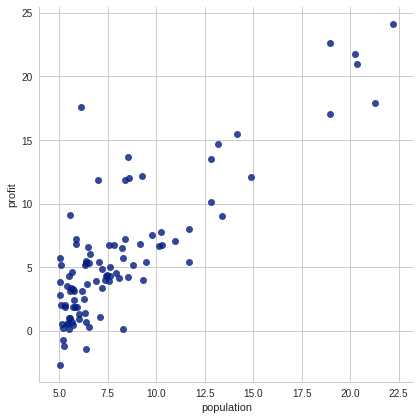

In [5]:
sns.lmplot('population','profit',df,size=6,fit_reg=False)
plt.show()

In [6]:
def get_X(df):  #读取X数据，其实就是整个data的除了最后一列的数据
    ones=pd.DataFrame({'ones':np.ones(len(df))})      #ones是m行1列的dataframe的数据
    data=pd.concat([df,ones],axis=1)                  #水平合并数据
    return np.array(data.iloc[:,:-1])                 #读取整个data除了最后一列之外的数据

def get_y(df):  #读取y数据
    return np.array(data.iloc[:,-1])                   #读取整个data最后一列的数据

def normaliaze_feature(df):          #特征缩放
     #就是把数据搞成均值为零，方差为1
    return df.apply(lambda column:(column-column.mean())/column.std())
    

多变量的假设 h 表示为：\\[{{h}_{\theta }}\left( x \right)={{\theta }_{0}}+{{\theta }_{1}}{{x}_{1}}+{{\theta }_{2}}{{x}_{2}}+...+{{\theta }_{n}}{{x}_{n}}\\] 
这个公式中有n+1个参数和n个变量，为了使得公式能够简化一些，引入${{x}_{0}}=1$，则公式转化为：  
此时模型中的参数是一个n+1维的向量，任何一个训练实例也都是n+1维的向量，特征矩阵X的维度是 m*(n+1)。 因此公式可以简化为：${{h}_{\theta }}\left( x \right)={{\theta }^{T}}X$，其中上标T代表矩阵转置。

In [7]:
def linear_regression(X_data, y_data, alpha, epoch, optimizer=tf.train.GradientDescentOptimizer):# 这个函数是旧金山的一个大神Lucas Shen写的
      # placeholder for graph input
    X = tf.placeholder(tf.float32, shape=X_data.shape)
    y = tf.placeholder(tf.float32, shape=y_data.shape)

    # construct the graph
    with tf.variable_scope('linearregressions'):
        W = tf.get_variable("weights",
                            (X_data.shape[1], 1),
                            initializer=tf.constant_initializer())  # n*1

        y_pred = tf.matmul(X, W)  # m*n @ n*1 -> m*1

        loss = 1 / (2 * len(X_data)) * tf.matmul((y_pred - y), (y_pred - y), transpose_a=True)  # (m*1).T @ m*1 = 1*1

    opt = optimizer(learning_rate=alpha)
    opt_operation = opt.minimize(loss)

    # run the session
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        loss_data = []

        for i in range(epoch):
            _, loss_val, W_val = sess.run([opt_operation, loss, W], feed_dict={X: X_data, y: y_data})
            loss_data.append(loss_val[0, 0])  # because every loss_val is 1*1 ndarray

            if len(loss_data) > 1 and np.abs(loss_data[-1] - loss_data[-2]) < 10 ** -9:  # early break when it's converged
                # print('Converged at epoch {}'.format(i))
                break

    # clear the graph
    tf.reset_default_graph()
    return {'loss': loss_data, 'parameters': W_val}  # just want to return in row vector format

# 开始读入数据

In [8]:
data=pd.read_csv('ex1data1.txt',names=['population','profit'])
data.head()

,population,profit
0,6.1101,17.5920
1,5.5277,9.1302
2,8.5186,13.6620
3,7.0032,11.8540
4,5.8598,6.8233


In [9]:
X=get_X(data)
print(X.shape,type(X))
y=get_y(data)
print(y.shape,type(y))

(97, 2) <class 'numpy.ndarray'>
(97,) <class 'numpy.ndarray'>


In [10]:
theta=np.zeros(X.shape[1])
print(theta.shape,type(theta))

(2,) <class 'numpy.ndarray'>


# 计算代价函数
$$J\left( \theta  \right)=\frac{1}{2m}\sum\limits_{i=1}^{m}{{{\left( {{h}_{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}} \right)}^{2}}}$$
其中：\\[{{h}_{\theta }}\left( x \right)={{X}}{\theta}={{\theta}_{0}}{{x}_{0}}+{{\theta }_{1}}{{x}_{1}}+{{\theta }_{2}}{{x}_{2}}+...+{{\theta }_{n}}{{x}_{n}}\\] 

In [11]:
def lr_cost(theta,X,y):
    inner=(X@theta-y).T@(X@theta-y)      #@作用同np.dot(多维就是矩阵乘法，一维就是点积并求和！)
    
    cost=(1/(2*len(X)))*inner             
    return cost
    
    

In [12]:
lr_cost(theta,X,y)



32.072733877455669

# batch gradient decent（批量梯度下降）
$${{\theta }_{j}}:={{\theta }_{j}}-\alpha \frac{\partial }{\partial {{\theta }_{j}}}J\left( \theta  \right)$$

In [13]:
def gradient(theta,X,y):
    m=X.shape[0]
    inner=X.T@(X@theta-y)
    return inner/m
    
    

In [14]:
def batch_gradient(theta,X,y,epoch,alpha=0.01):
    
    cost_data=[lr_cost(theta,X,y)]
    _theta=theta.copy()
    for _ in range(epoch):
        _theta=_theta-alpha*gradient(_theta,X,y)
        cost_data.append(lr_cost(_theta,X,y))
        
    return _theta,cost_data
        
    

In [15]:
epoch=500
final_theta,cost_data=batch_gradient(theta,X,y,epoch)

In [16]:
final_theta

array([  2.66992347e-16,   1.00000000e+00])

In [17]:
cost_data


[32.072733877455669,
 6.1919207269854146,
 2.1361941533723625,
 1.3689193341764805,
 1.1147701223651465,
 0.95587454300633468,
 0.82728214086363927,
 0.71714676053751425,
 0.6218470738005305,
 0.53923745292430592,
 0.46760603392425387,
 0.40549059551791877,
 0.3516264797884957,
 0.30491751946389012,
 0.26441323308305875,
 0.22928940928308722,
 0.19883132401451914,
 0.17241919517549698,
 0.14951557060993215,
 0.12965439162434714,
 0.11243150929971532,
 0.097496460590684952,
 0.084545336862564949,
 0.07331459974955766,
 0.063575718494981864,
 0.055130519650386053,
 0.047807154506032151,
 0.041456602195252962,
 0.035949637315448264,
 0.031174200360787267,
 0.027033117458375423,
 0.023442123007509523,
 0.020328144985326119,
 0.017627818027064483,
 0.015286194024078778,
 0.013255624001962483,
 0.011494788526471839,
 0.0099678569072830601,
 0.0086437580904819879,
 0.0074955484034067901,
 0.0064998632862805199,
 0.0056364418540923956,
 0.0048877146141860202,
 0.0042384459501489009,
 0.0036754

In [18]:
lr_cost(final_theta,X,y)

7.7031638390082954e-31

# visualize  cost data   数据可视化

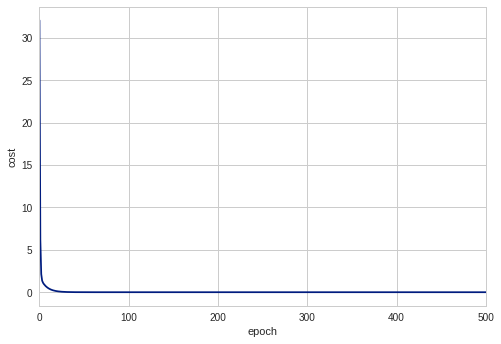

In [19]:
ax=sns.tsplot(cost_data,time=np.arange(epoch+1))
ax.set_xlabel('epoch')
ax.set_ylabel('cost')
plt.show()

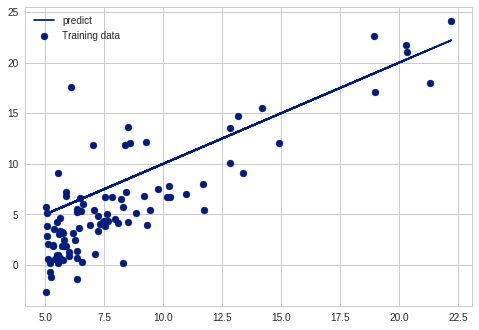

In [20]:
b=final_theta[0]    #b截距
m=final_theta[1]    #m是斜率
plt.scatter(data.population,data.profit,label='Training data')
plt.plot(data.population,data.population*m+b,label='predict')
plt.legend(loc=2)
plt.show()


# 3 选修章节

In [21]:
raw_data=pd.read_csv('ex1data2.txt',names=['square','room','price'])
raw_data.head()

,square,room,price
0,2104,3,399900
1,1600,3,329900
2,2400,3,369000
3,1416,2,232000
4,3000,4,539900


In [22]:
data=normaliaze_feature(raw_data)   #归一化
data.head()

,square,room,price
0,0.130010,-0.223675,0.475747
1,-0.504190,-0.223675,-0.084074
2,0.502476,-0.223675,0.228626
3,-0.735723,-1.537767,-0.867025
4,1.257476,1.090417,1.595389


# 2. multi-var batch gradient decent（多变量批量梯度下降）

In [23]:
X=get_X(data)
print(X.shape,type(X))
y=get_y(data)
print(y.shape,type(y))

(47, 3) <class 'numpy.ndarray'>
(47,) <class 'numpy.ndarray'>


In [24]:
alpha=0.01
epoch=500
theta=np.zeros((X.shape[1]))

In [37]:
final_theta,cost_data=batch_gradient(theta,X,y,epoch,alpha=alpha)

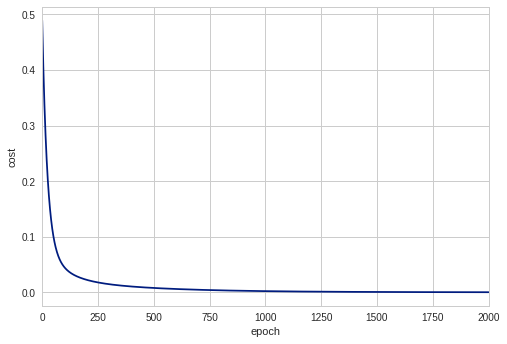

In [38]:
ax=sns.tsplot(cost_data,time=np.arange(epoch+1))
ax.set_xlabel('epoch')
ax.set_ylabel('cost')
plt.show()

In [39]:
final_theta

array([ 0.03595616, -0.0069401 ,  0.9680825 ])

# 学习率

In [28]:
base=np.logspace(-1,-5,num=4)
candidate=np.sort(np.concatenate((base,base*3)))
print(candidate)

[  1.00000000e-05   3.00000000e-05   2.15443469e-04   6.46330407e-04
   4.64158883e-03   1.39247665e-02   1.00000000e-01   3.00000000e-01]


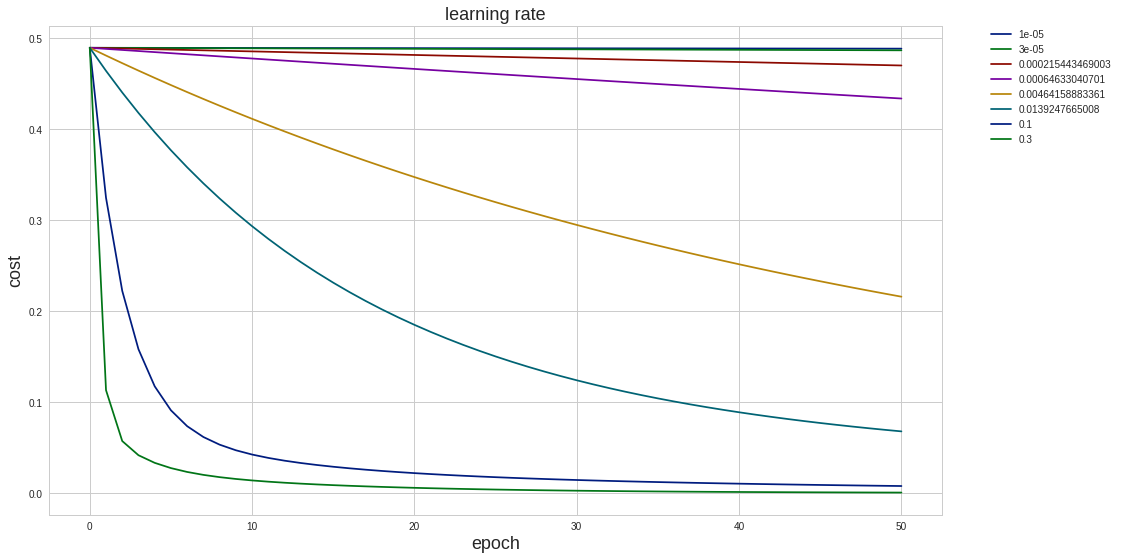

In [29]:
epoch=50
fig,ax=plt.subplots(figsize=(16,9))

for alpha in candidate:
    _,cost_data=batch_gradient(theta,X,y,epoch,alpha=alpha)
    ax.plot(np.arange(epoch+1),cost_data,label=alpha)
    
ax.set_xlabel('epoch',fontsize=18)
ax.set_ylabel('cost',fontsize=18)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_title('learning rate',fontsize=18)
plt.show()

# # 4. normal equation（正规方程）
正规方程是通过求解下面的方程来找出使得代价函数最小的参数的：$\frac{\partial }{\partial {{\theta }_{j}}}J\left( {{\theta }_{j}} \right)=0$ 。
 假设我们的训练集特征矩阵为 X（包含了${{x}_{0}}=1$）并且我们的训练集结果为向量 y，则利用正规方程解出向量 $\theta ={{\left( {{X}^{T}}X \right)}^{-1}}{{X}^{T}}y$ 。
上标T代表矩阵转置，上标-1 代表矩阵的逆。设矩阵$A={{X}^{T}}X$，则：${{\left( {{X}^{T}}X \right)}^{-1}}={{A}^{-1}}$

梯度下降与正规方程的比较：

梯度下降：需要选择学习率α，需要多次迭代，当特征数量n大时也能较好适用，适用于各种类型的模型	

正规方程：不需要选择学习率α，一次计算得出，需要计算${{\left( {{X}^{T}}X \right)}^{-1}}$，如果特征数量n较大则运算代价大，因为矩阵逆的计算时间复杂度为O(n3)，通常来说当n小于10000 时还是可以接受的，只适用于线性模型，不适合逻辑回归模型等其他模型

In [30]:
def normalEqn(X,y):
    theta=np.linalg.inv(X.T@X)@X.T@y
    return theta

In [31]:
final_theta2=normalEqn(X,y)
final_theta2

array([ -6.10622664e-16,   9.71445147e-17,   1.00000000e+00])

# Tensorflow 实现

In [42]:
X_data=get_X(data)
print(X_data.shape,type(X_data))
y_data=get_y(data).reshape(len(X_data),1)
print(y_data.shape,type(y_data))

(47, 3) <class 'numpy.ndarray'>
(47, 1) <class 'numpy.ndarray'>


In [43]:
epoch=2000
alpha=0.01

In [44]:
optimizer_dict={'GD': tf.train.GradientDescentOptimizer,
                'Adagrad': tf.train.AdagradOptimizer,
                'Adam': tf.train.AdamOptimizer,
                'Ftrl': tf.train.FtrlOptimizer,
                'RMS': tf.train.RMSPropOptimizer
               }
results = []
for name in optimizer_dict:
    res = linear_regression(X_data, y_data, alpha, epoch, optimizer=optimizer_dict[name])
    res['name'] = name
    results.append(res)

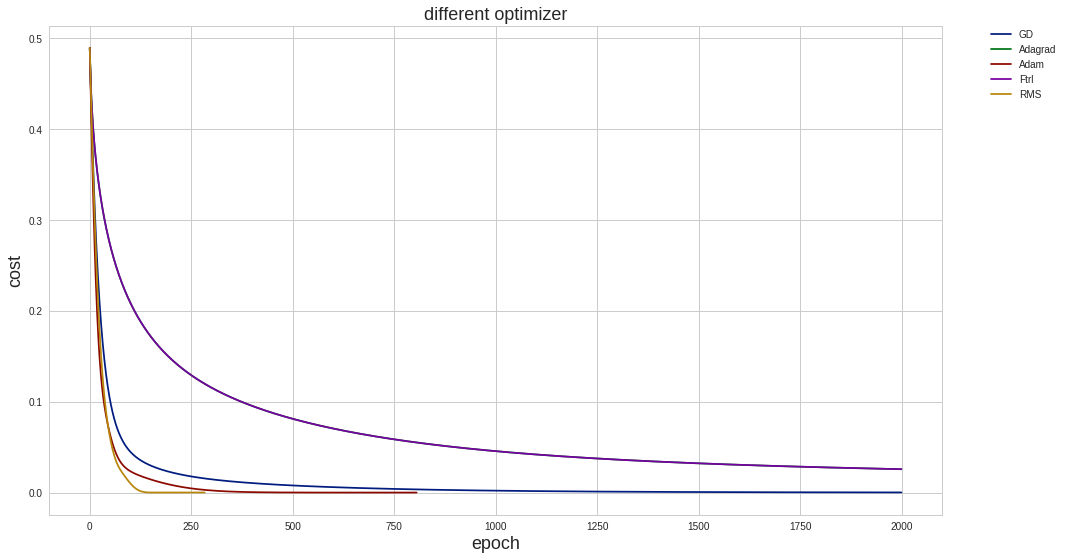

In [45]:
fig, ax = plt.subplots(figsize=(16, 9))

for res in results: 
    loss_data = res['loss']
    
#     print('for optimizer {}'.format(res['name']))
#     print('final parameters\n', res['parameters'])
#     print('final loss={}\n'.format(loss_data[-1]))
    ax.plot(np.arange(len(loss_data)), loss_data, label=res['name'])

ax.set_xlabel('epoch', fontsize=18)
ax.set_ylabel('cost', fontsize=18)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_title('different optimizer', fontsize=18)
plt.show()